In [1]:
import pybedtools as pbt
import numpy as np
from tqdm import tqdm
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, wilcoxon, ttest_ind, chisquare
from ipyparallel import Client

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

28

## The objective here is to check whether the expectation scores are higher in g4-chipSeq peaks compared to random peaks and how this compares to G4 motifs detected by QuadParser

### We start by first extracting peak sequences and creating random peaks and saving them

In [45]:
_ = pbt.BedTool('../data/chip_seq_g4/rhh175_ChIPwthacat_704_502_entst_26082015_peaks.narrowPeak').saveas(
    '../data/chip_seq_g4/hacat_peaks_rep1.bed')
_ = pbt.BedTool('../data/chip_seq_g4/rhh_25cyc_BG4_12082015_peaks.narrowPeak').saveas(
    '../data/chip_seq_g4/hacat_peaks_rep2.bed')

In [61]:
!bedtools intersect \
    -a ../data/chip_seq_g4/hacat_peaks_rep1.bed \
    -b ../data/chip_seq_g4/hacat_peaks_rep2.bed | \
    awk 'BEGIN{OFS="\t"}{print $1,$2,$3}' > ../data/chip_seq_g4/common_peaks.bed

In [121]:
!wc -l ../data/chip_seq_g4/common_peaks.bed

11691 ../data/chip_seq_g4/common_peaks.bed


In [65]:
peaks_bed = pbt.BedTool('../data/chip_seq_g4/common_peaks.bed')
genome_info_fn = '/home/parashar/scratch/hg19_resource/hg19.genome'
for i in tqdm(range(100)):
    out_fn = '../data/chip_seq_g4/random_regions/random_peaks_%d.bed' % i
    _ = peaks_bed.shuffle(g=genome_info_fn, chrom=True).saveas(out_fn)

100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


In [69]:
def get_chrom_seq(chrom):
    fasta_base_dir ='/home/parashar/scratch/hg19_resource/chromosomes'
    chrom_seq = "".join([x.rstrip('\n') for x in
               open("%s/%s.fa" % (fasta_base_dir, chrom)).readlines()[1:]]).upper()
    return chrom_seq

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_name_idx = {x:n for n,x in enumerate(chroms)}
chrom_seqs = DVIEW.map_sync(get_chrom_seq, chroms)

In [70]:
def extract_seq(bed_file, out_name):
    chrom_wise_intervals = {}
    for chrom in chroms:
        chrom_wise_intervals[chrom] = []
    with open (bed_file) as h:
        for l in h:
            c = l.split('\t')
            if c[0] in chroms:
                chrom_wise_intervals[c[0]].append((int(c[1]), int(c[2])))
    
    sequences = []
    for chrom in chroms:
        for span in chrom_wise_intervals[chrom]:
            sequences.append(chrom_seqs[chrom_name_idx[chrom]][span[0]:span[1]])
    with open(out_name, 'w') as OUT:
        OUT.write("\n".join(sequences))
    return None

_ = extract_seq('../data/chip_seq_g4/common_peaks.bed',
            '../data/chip_seq_g4/common_peaks.seq')
for i in tqdm(range(100)):
    in_fn = '../data/chip_seq_g4/random_regions/random_peaks_%d.bed' % i
    out_fn = '../data/chip_seq_g4/random_regions/random_peaks_%d.seq' % i
    _ = extract_seq(in_fn, out_fn)

100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


### Lets now calculate the G4Hunter scores of the peaks and random peaks

In [12]:
%%writefile G4Hunter_chip_seq_wrapper.py

import os

script = '/home/parashar/scratch/quadcomb/scripts/G4Hunter.r'
in_fn = '../data/chip_seq_g4/common_peaks.seq'
out_fn = '../data/chip_seq_g4/g4hunter_scores.txt'
bsub = "bsub -n 2 -q debugq -J peaks -o g4hunter_chipseq_logs/peaks.log"
cmd = '%s Rscript %s %s %s' % (bsub, script, in_fn, out_fn)
os.system(cmd)

for i in range(100):
    in_fn = '../data/chip_seq_g4/random_regions/random_peaks_%d.seq' % i
    out_fn = '../data/chip_seq_g4/g4hunter_random/random_%d.txt' % i
    bsub = "bsub -n 2 -q debugq -J %d -o g4hunter_chipseq_logs/%d.log" % (i, i)
    cmd = '%s Rscript %s %s %s' % (bsub, script, in_fn, out_fn)
    os.system(cmd)

Overwriting G4Hunter_chip_seq_wrapper.py


In [ ]:
! mkdir g4hunter_chipseq_logs
! python G4Hunter_chip_seq_wrapper.py
clear_output()

### Now lets load and the expectation scores and calculate the Expectation scores in each of the G4-Chip and random genomic location of equivalent span

In [125]:
def calc_score_in_span(chrom):
    import numpy as np
    
    def load_scores(strand):
        in_dir = '/home/parashar/scratch/quadcomb/data/QG_expectation_scores_corrected_values'
        fn = '%s/%s_%s.npy' % (in_dir, chrom, strand)
        return np.load(fn, mmap_mode='r')

    def calc(fn):
        ac = 0
        scores = []
        with open(fn) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                if c[0] == chrom:
                    p = pos[int(c[1]):int(c[2])]
                    n = neg[int(c[1]):int(c[2])]
                    if p.max() > 0.01 or n.max() > 0.01:
                        ac += 1
                    scores.append(sum(p+n))
        return scores, ac
    
    pos = load_scores('positive')
    neg = load_scores('negative')
    in_dir = '/home/parashar/scratch/quadcomb/data/chip_seq_g4'
    peak_s, above_cutoff = calc('%s/common_peaks.bed' % in_dir)

    rand_s = []
    for i in range(100):
        in_fn = '%s/random_regions/random_peaks_%d.bed' % (in_dir, i)
        rand_s.append(calc(in_fn))
    
    return peak_s, rand_s, above_cutoff
    

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(calc_score_in_span, chroms)

peak_scores = []
random_scores = [[] for x in range(100)]
above_cutoff = []
for i in res:
    peak_scores.extend(i[0])
    for n,j in enumerate(i[1]):
        random_scores[n].extend(j)
    above_cutoff.append(i[2])
print (sum(above_cutoff))
np.save('../data/chip_seq_g4/peaks_exp_scores', np.array(peak_scores))
np.save('../data/chip_seq_g4/peaks_exp_random_scores',  np.array(random_scores))

7720


In [122]:
7720/11691

0.6603370113762723

### Now lets calculate the number of G4 motifs of various configurations that occur in Peaks and random regions

In [5]:
g4_base_dir = '/home/parashar/scratch/quadruplexes/hg19'

peak_motifs = []
random_motifs = []
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info_file = '/home/parashar/scratch/hg19_resource/hg19.genome'
chrom_info = [x.rstrip('\n').split('\t') for x in
              open(chrom_info_file).readlines()]
chrom_info = {x[0]: (0, int(x[1])) for x in chrom_info}

peaks_bed = pbt.BedTool('../data/chip_seq_g4/peaks.bed').set_chromsizes(chrom_info)
# random_peaks = pbt.BedTool('./data/chip_seq_g4/random_peaks.bed')
for chrom in chroms:
    chrom_wise = []
    chrom_wise_random = []
    for bulge in [0, 3]:
        for loop in [7, 15]:
            print (chrom, loop, bulge)
            g4_motifs = pbt.BedTool('%s/g3_%s_%s_%s_nov.bed' % (g4_base_dir, loop, bulge, chrom))
            chrom_wise.append(peaks_bed.intersect(g4_motifs, u=True).count())
            # chrom_wise.append(random_peaks.intersect(g4_motifs, u=True).count())
            chrom_wise_random.append(np.mean(list(
                        peaks_bed.randomintersection(g4_motifs, iterations=10, processes=15,
                                                     shuffle_kwargs={'chrom': False})
            )))
            clear_output()
    peak_motifs.append(list(chrom_wise))
    random_motifs.append(list(chrom_wise_random))

peak_motifs = np.array(peak_motifs)
random_motifs = np.array(random_motifs)

np.save('../data/chip_seq_g4/peaks_motifs', peak_motifs.sum(axis=0))
np.save('../data/chip_seq_g4/random_peaks_motifs', random_motifs.sum(axis=0))

### Time to plot data

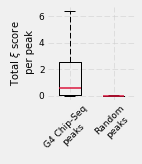

In [37]:
peak_exp = np.load('../data/chip_seq_g4/peaks_exp_scores.npy')
random_exp = np.load('../data/chip_seq_g4/peaks_exp_random_scores.npy')

fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([peak_exp, random_exp[2]], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylabel(r'Total $\xi$ score'+'\n per peak', fontsize=10)
ax.set_xticklabels(['G4 Chip-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/g4_chip_seq_exp_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chip_seq_exp_scores.svg', transparent=True, edgecolor='none')
plt.show()

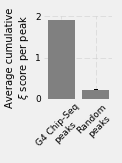

[1.9161134069582291, 0.21746230836910604] 8.81124375681 Power_divergenceResult(statistic=1330.327334646795, pvalue=1.3491147977222946e-214)


In [104]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))
x = [1,2]
y = [peak_exp.mean(), random_exp.mean()]
ax.bar(x, y, yerr=[0, random_exp.mean(axis=1).std()], color='grey')
ax.set_ylabel('Average cumulative\n' + r'$\xi$' + ' score per peak', fontsize=10)
ax.set_xticklabels(['', 'G4 Chip-Seq\npeaks', 'Random\npeaks'],
                   rotation=45, fontsize=10, ha='center')
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/g4_chip_seq_exp_scores_bootstrap.png',
            dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chip_seq_exp_scores_bootstrap.svg',
            transparent=True, edgecolor='none')
plt.show()
print (y, y[0]/y[1], chisquare([peak_exp.mean()], random_exp.mean(axis=1)))

In [64]:
def load_hunter(fn):
    s = []
    with open(fn) as h:
        next(h)
        for l in h:
            c = l.rstrip('\n').split('\t')
            s.append(float(c[1]))
    s = np.array(s)
    return s

peak_hunter_scores = load_hunter('../data/chip_seq_g4/g4hunter_scores.txt')
random_hunter_scores = []
for i in tqdm(range(100)):
    in_fn = '../data/chip_seq_g4/g4hunter_random/random_%d.txt' % i
    random_hunter_scores.append(load_hunter(in_fn))
random_hunter_scores = np.array(random_hunter_scores)

100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


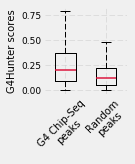

In [107]:
boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))
a = peak_hunter_scores[peak_hunter_scores > 0]
b = np.array(random_hunter_scores[0])
b = b[b > 0]
ax.boxplot([a, b], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)

ax.set_ylabel('G4Hunter scores', fontsize=10)
clean_axis(ax)
ax.set_xticklabels(['G4 Chip-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=10)

plt.tight_layout()
plt.savefig('../images/g4_chip_seq_hunter_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chip_seq_hunter_scores.svg', transparent=True, edgecolor='none')
plt.show()

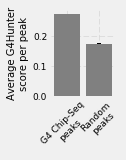

[0.27239878116826505, 0.1744260898402813] 1.56168599215 Power_divergenceResult(statistic=5.5119194936208, pvalue=1.0)


In [102]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))

a = peak_hunter_scores[peak_hunter_scores > 0].mean()
b = []
for i in range(100):
    temp = random_hunter_scores[i]
    temp = temp[temp > 0]
    b.append(temp.mean())
b = np.array(b)

x = [1,2]
y = [a, b.mean()]
ax.bar(x, y, yerr=[0, b.std()], color='grey')
ax.set_ylabel('Average G4Hunter\n' + 'score per peak', fontsize=10)
ax.set_xticklabels(['', 'G4 Chip-Seq\npeaks', 'Random\npeaks'],
                   rotation=45, fontsize=10, ha='center')
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/g4_chip_seq_hunter_scores_bootstrap.png',
            dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chip_seq_hunter_scores_bootstrap.svg',
            transparent=True, edgecolor='none')
plt.show()
print (y, y[0]/y[1], chisquare([a], b))

In [127]:
print (len(peak_hunter_scores[peak_hunter_scores > 0]))
print (len(peak_hunter_scores[peak_hunter_scores > 1]))

5735
103


In [126]:
5735/11691

0.49054828500555986